In [43]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from particle_filter import filter
from models import SEIR_model,SEIR_Obs
from pmcmc import PMCMC
from scipy.stats import beta

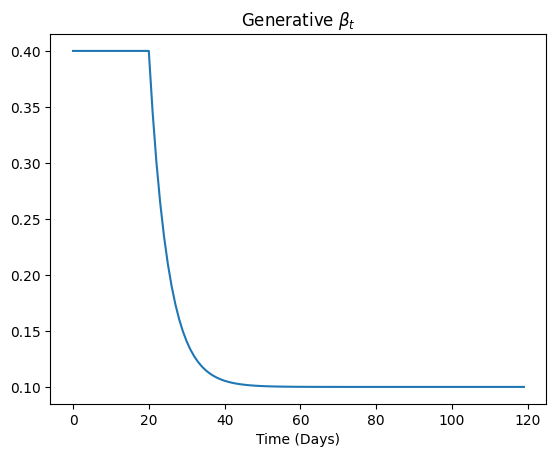

In [44]:
'''Simulated Data, setting up the SIR model'''

rng = np.random.default_rng(0)

gamma = 1/14
eta = 1/7
q = 0.1
mu = 0.004
rho = 0.1

T = 120
dt = 1.
t_vec = np.arange(0,T,dt)

N = 100_000
I = 5
E = 5


beta_par = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_par,t) for t in t_vec])

state = np.zeros((5,len(t_vec)))
state[:,0] = np.array([N - I - E,E, I, 0,0])

plt.title('Generative $\\beta_t$')
plt.xlabel('Time (Days)')
plt.plot(t_vec,betas)

for time_index in range(1,len(t_vec)):

    #new_E = rng.poisson((betas[time_index - 1] * (state[1,time_index -1] + q * state[2,time_index - 1]) * state[0,time_index - 1]/np.sum(state[:,time_index-1])) * dt)
    # new_I = rng.poisson((eta * state[1,time_index - 1]) * dt)
    # new_ER = rng.poisson((gamma * state[1,time_index -1]) * dt)
    # new_IR = rng.poisson((gamma * state[2,time_index - 1]) * dt)
    # new_D = rng.poisson((mu * state[2,time_index - 1]) * dt)

    new_E = ((betas[time_index - 1] * (state[1,time_index -1] + q * state[2,time_index - 1]) * state[0,time_index - 1]/np.sum(state[:,time_index-1])) * dt)
    new_I = ((eta * state[1,time_index - 1]) * dt)
    new_ER = ((gamma * state[1,time_index -1]) * dt)
    new_IR = ((gamma * state[2,time_index - 1]) * dt)
    new_D = ((mu * state[2,time_index - 1]) * dt)


    state[0,time_index] = np.maximum(0.,state[0,time_index - 1] - new_E) #S 
    state[1,time_index] = np.maximum(0.,state[1,time_index - 1] + new_E - new_I - new_ER) #E
    state[2,time_index] = np.maximum(0.,state[2,time_index-1] + new_I - new_IR - new_D) #I
    state[3,time_index] = np.maximum(0.,state[3,time_index - 1] + new_ER + new_IR)
    state[4,time_index] = state[4,time_index - 1] + new_E

    

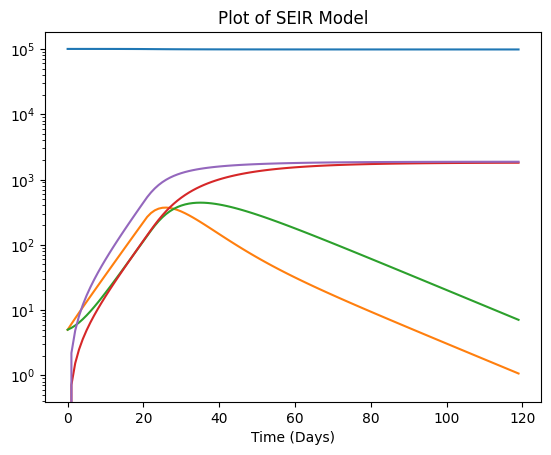

In [45]:
plt.yscale('log')
plt.title('Plot of SEIR Model')
plt.xlabel('Time (Days)')
plt.plot(t_vec,state.T)

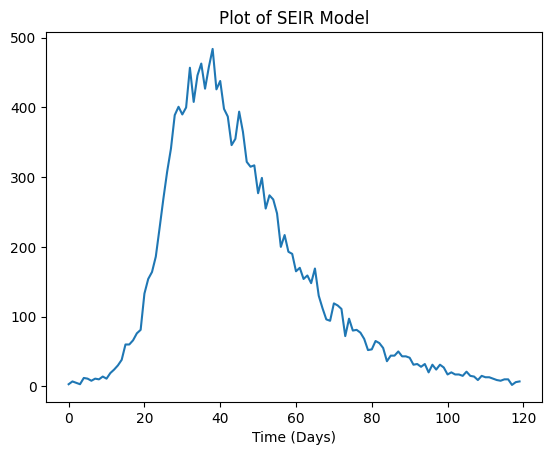

In [46]:
n = 100
sigma = 0.1

data = rng.poisson(state[2,::int(1/dt)])
# data = np.sum(data, axis = 0)

#data = np.concatenate(([0],np.diff(state[4,::int(1/dt)])))

#data = rng.negative_binomial(p = n/(state[4,::int(1/dt)] + n),n = n)
#data = np.exp(rng.normal(np.log(state[4,::int(1/dt)]),sigma))
plt.title('Plot of SEIR Model')
plt.xlabel('Time (Days)')
plt.plot(data)

In [47]:

#(0.06547914,0.28245005)
#(1/14 = 0.07,1/7 = 0.14)
particles, particle_observations,weights,likelihood = filter(data = data,
                              theta= (gamma,eta),
                              rng = rng,
                              num_particles = 1000,
                              dt = 1.,
                              model = SEIR_model,
                              observation=SEIR_Obs,
                              model_dim = 5,
                              observation_dim=1)

 Log Likelihood : -518.6936817466221
Root Mean Squared Error for the Data 146.79220260094263


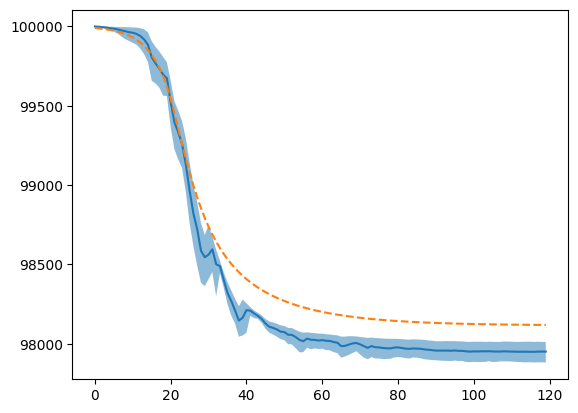

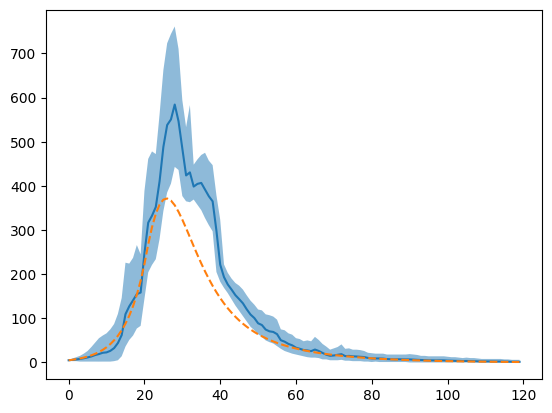

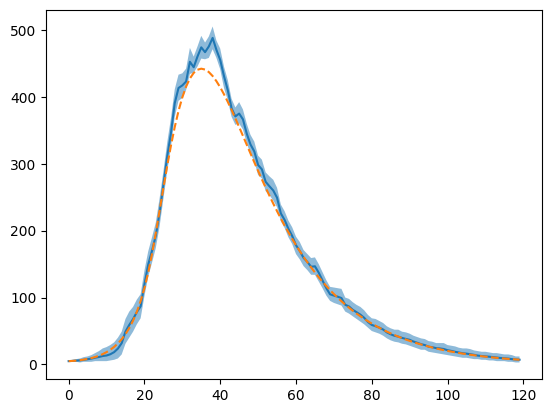

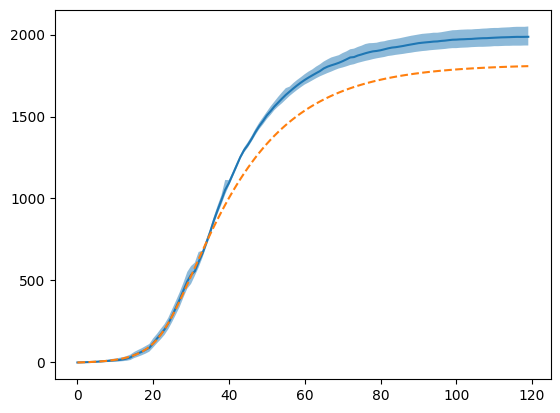

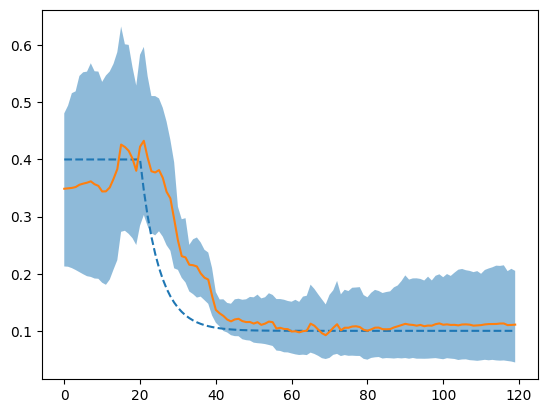

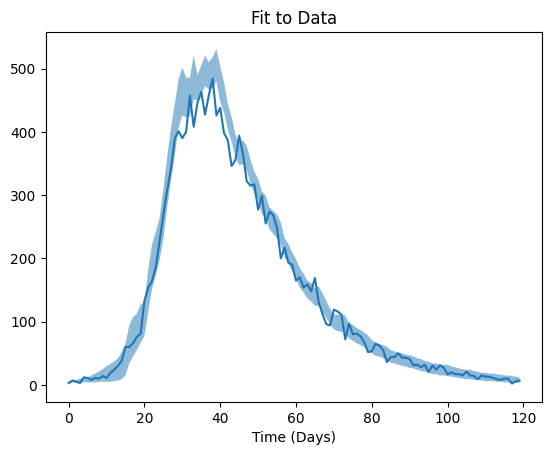

In [48]:
print(f" Log Likelihood : {np.sum((likelihood))}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(particle_observations[:,0,:]))**2))}")

for i in range(4):
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(particles[:,i,:].T,5,axis = 1),np.percentile(particles[:,i,:].T,95,axis = 1),alpha = 0.5)
    plt.plot(np.average(particles[:,i,:],weights = weights,axis = 0))
    plt.plot(t_vec,state[i,:].T,'--')
    plt.show()

plt.plot(t_vec,betas,'--')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(particles[:,4,:].T,5,axis = 1),np.percentile(particles[:,4,:].T,95,axis = 1),alpha = 0.5)
plt.plot(np.average(particles[:,4,:],weights = weights,axis = 0))
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data)
plt.fill_between(t_vec[::int(1/dt)],np.percentile(particle_observations[:,0,:].T,5,axis = 1),np.percentile(particle_observations[:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()


In [49]:
pmcmc_rng = np.random.default_rng(0)

iterations = 10_000

num_particles = 10000

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)


def prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 1/28.,max_val= 1/7) + uniform_numba_logpdf(theta[1],min_val = 1/15.,max_val = 1/3)
theta, LL, MLE_Distribution = PMCMC(iterations=iterations,
                  num_particles=num_particles,
                  init_theta=np.array([rng.uniform(1/28,1/7),rng.uniform(1/15,1/3)]),
                  data = data,
                  rng = pmcmc_rng,
                  dt = 1., 
                  prior = prior, 
                  model = SEIR_model,
                  observation = SEIR_Obs,
                  model_dim=5,
                  observation_dim=1)




iteration: 10| Acceptance rate: 0.0| Log-Likelihood: -507.22602376432246| Proposal [0.05651305 0.16491747]
iteration: 20| Acceptance rate: 0.15| Log-Likelihood: -498.226996078266| Proposal [0.09687186 0.15744076]
iteration: 30| Acceptance rate: 0.16666666666666666| Log-Likelihood: -497.8499677469133| Proposal [0.0900964  0.24379585]
iteration: 40| Acceptance rate: 0.2| Log-Likelihood: -498.4598767820203| Proposal [0.10816247 0.23360286]
iteration: 50| Acceptance rate: 0.26| Log-Likelihood: -498.895838925819| Proposal [0.10021255 0.22532416]
iteration: 60| Acceptance rate: 0.3333333333333333| Log-Likelihood: -498.78866852572685| Proposal [0.10477743 0.22323024]
iteration: 70| Acceptance rate: 0.37142857142857144| Log-Likelihood: -498.37611407490766| Proposal [0.10440816 0.21984346]
iteration: 80| Acceptance rate: 0.4| Log-Likelihood: -497.8905509576796| Proposal [0.09653021 0.1768849 ]
iteration: 90| Acceptance rate: 0.4| Log-Likelihood: -499.45275117970925| Proposal [0.1301213  0.08516

-494.8983910794184
The Maximum Likelihood Estimate is [0.06703276 0.15604365] w/ LL of -494.8983910794184


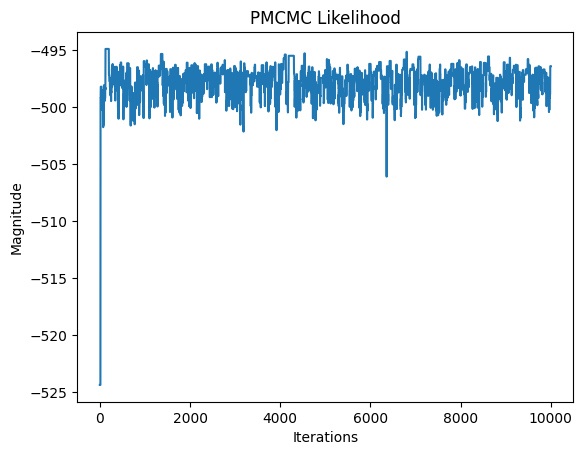

In [8]:
burn_in = 1000


MLE = np.argmax(LL)

print(LL[MLE])

print(f"The Maximum Likelihood Estimate is {theta[:,MLE]} w/ LL of {LL[MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(LL)

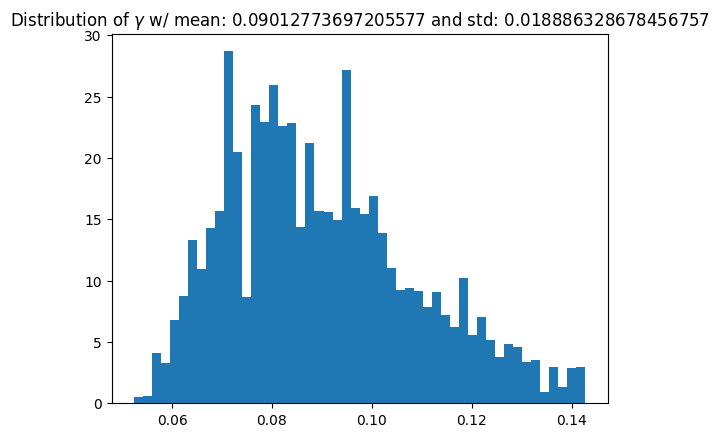

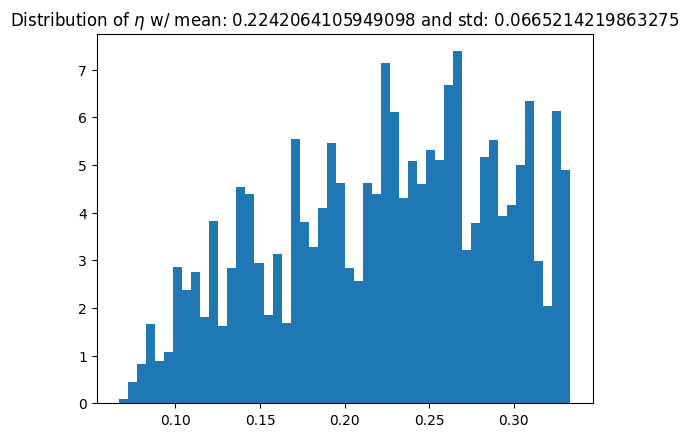

In [9]:
plt.title(f"Distribution of $\\gamma$ w/ mean: {np.mean(theta[0,burn_in:])} and std: {np.std(theta[0,burn_in:])}")
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\eta$ w/ mean: {np.mean((theta[1,burn_in:]))} and std: {np.std((theta[1,burn_in:]))}")
plt.hist((theta[1,burn_in:]),density=True,bins = 50)
plt.show()

# plt.title(f"Distribution of n w/ mean: {np.mean(theta[2,burn_in:])} and std: {np.std(theta[2,burn_in:])}")
# plt.hist(theta[2,burn_in:],density=True,bins = 50)
# plt.show()




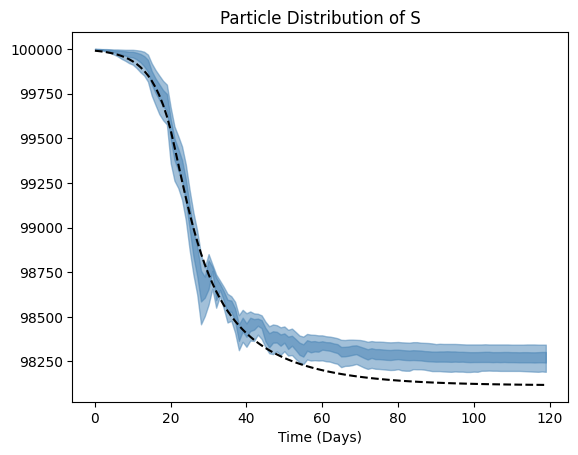

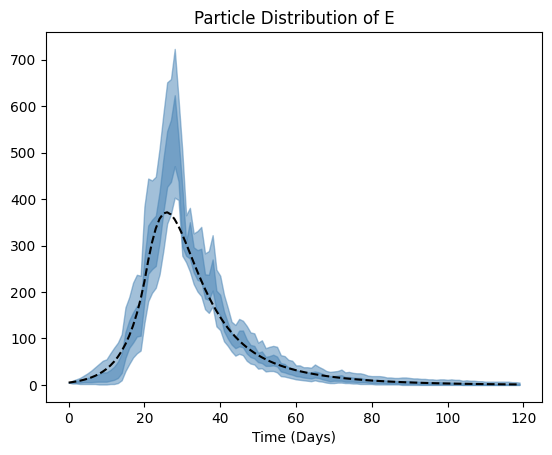

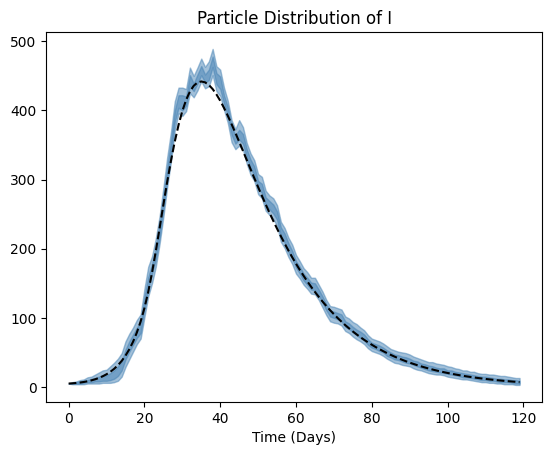

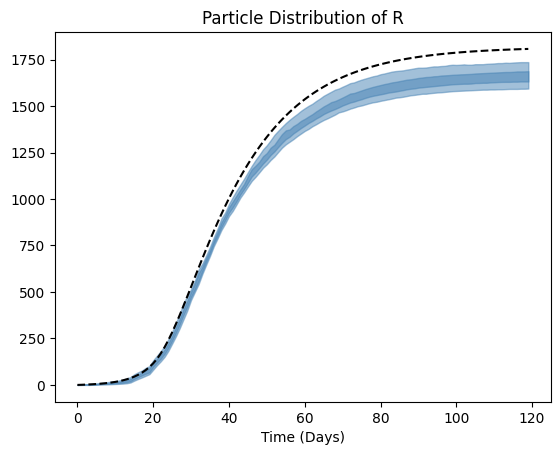

In [42]:
Labels = ['S','E','I','R']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.xlabel('Time (Days)')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    #plt.plot(t_vec[::int(1/dt)],[i,:,MLE])
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Distribution[:,i,:].T,5,axis = 1),np.percentile(MLE_Distribution[:,i,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Distribution[:,i,:].T,25,axis = 1),np.percentile(MLE_Distribution[:,i,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.show()

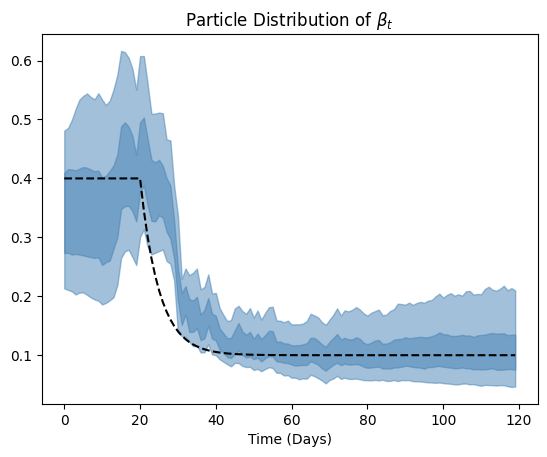

In [38]:
plt.title("Particle Distribution of $\\beta_t$")
plt.xlabel("Time (Days)")
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Distribution[:,4,:].T,5,axis = 1),np.percentile(MLE_Distribution[:,4,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.fill_between(t_vec[::int(1/dt)],np.percentile(MLE_Distribution[:,4,:].T,25,axis = 1),np.percentile(MLE_Distribution[:,4,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.show()